In this part of the exercise, you will implement the collaborative ﬁltering learning algorithm and apply it to a dataset of movie ratings.2 This dataset consists of ratings on a scale of 1 to 5. The dataset has nu = 943 users, and nm = 1682 movies. For this part of the exercise, you will be working with the script ex8 cofi.m. In the next parts of this exercise, you will implement the function cofiCostFunc.m that computes the collaborative ﬁtlering objective function and gradient. After implementing the cost function and gradient, you will use fmincg.m to learn the parameters for collaborative ﬁltering.


# 1 Movie ratings dataset

In [1]:
#Importing...

import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D




#Reading the .mat file

mat_contents = sio.loadmat('E:\Machine Learning\Exercises\machine-learning-ex8\ex8\ex8_movies.mat')

mat_contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
# The matrix Y (a num_movies×num_users matrix) stores the ratings y(i,j) (from 1 to 5). The matrix R is an binary-valued 
# indicator matrix, where R(i,j) = 1 if user j gave a rating to movie i, and R(i,j) = 0 otherwise. The objective of 
# collaborative ﬁltering is to predict movie ratings for the movies that users have not yet rated, that is, the entries 
# with R(i,j) = 0. This will allow us to recommend the movies with the highest predicted ratings to the user. 

In [3]:
#%  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
Y = mat_contents['Y']

#%  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
R = mat_contents['R']

In [4]:
print('Average movie rating of movie 1 (Toy Story): ',np.mean(Y[0][np.where(R[0] == 1)]))

Average movie rating of movie 1 (Toy Story):  3.8783185840707963


In [5]:
# Throughout this part of the exercise, you will also be working with the matrices, X and Theta. The i-th row of X 
# corresponds to the feature vector x(i) for the i-th movie, and the j-th row of Theta corresponds to one parameter 
# vector θ(j), for the j-th user. Both x(i) and θ(j) are n-dimensional vectors. For the purposes of this exercise, 
# you will use n = 100, and therefore, x(i) ∈R100 and θ(j) ∈R100. Correspondingly, X is a nm ×100 matrix and Theta 
# is a nu ×100 matrix. 

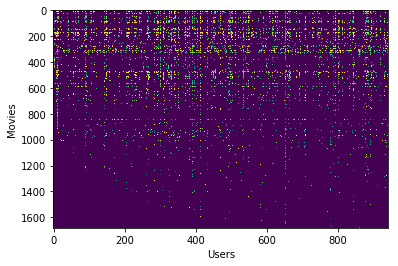

In [6]:
#  We can "visualize" the ratings matrix by plotting it with imagesc
plt.imshow(Y,aspect='auto')
plt.ylabel('Movies');
plt.xlabel('Users');


array([[5, 4, 0, 0, 4],
       [3, 0, 0, 0, 3],
       [4, 0, 0, 0, 0],
       [3, 0, 0, 0, 0],
       [3, 0, 0, 0, 0]], dtype=uint8)

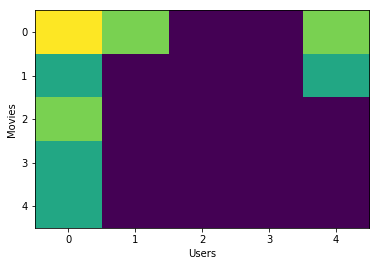

In [7]:
#  Understanding the meaning of the above imshow in small data
plt.imshow(Y[0:5,0:5],aspect='auto')
plt.ylabel('Movies');
plt.xlabel('Users');
Y[0:5,0:5]


# 2 Collaborative filtering

Now, you will start implementing the collaborative ﬁltering learning algorithm. You will start by implementing the cost function (without regularization). 

In [8]:
#The collaborative ﬁltering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter 
#vectors x(1),...,x(nm) and θ(1),...,θ(nu), where the model predicts the rating for movie i by user j as y(i,j) = (θ(j))'x(i)
#Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter 
#vectors x(1),...,x(nm),θ(1),...,θ(nu) that produce the best ﬁt (minimizes the squared error). You will complete the code in
#cofiCostFunc.m to compute the cost function and gradient for collaborative ﬁltering. Note that the parameters to the 
#function (i.e., the values that you are trying to learn) are X and Theta. In order to use an oﬀ-the-shelf minimizer such as
#fmincg, the cost function has been set up to unroll the parameters into a single vector params. You had previously used the
#same vector unrolling method in the neural networks programming exercise.


## 2.1 Collaborative Cost Function

In [9]:
# We will compute the cost function without regularization
# Note that you should be accumulating the cost for user j and movie i only if R(i,j) = 1. 

In [10]:
#%% ============ Part 2: Collaborative Filtering Cost Function ===========
#%  You will now implement the cost function for collaborative filtering.
#%  To help you debug your cost function, we have included set of weights
#%  that we trained on that. Specifically, you should complete the code in 
#%  cofiCostFunc.m to return J.

#%  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
PreTrainedWeights = sio.loadmat('E:\Machine Learning\Exercises\machine-learning-ex8\ex8\ex8_movieParams.mat')

X = PreTrainedWeights['X']
Theta = PreTrainedWeights['Theta']
num_users = PreTrainedWeights['num_users']
num_movies = PreTrainedWeights['num_movies']
num_features = PreTrainedWeights['num_features']

In [11]:
#%  Reduce the data set size so that this runs faster

num_usersReduced = 4
num_moviesReduced = 5 
num_featuresReduced = 3

XReduced     = X[0:num_moviesReduced, 0:num_featuresReduced]
ThetaReduced = Theta[0:num_usersReduced, 0:num_featuresReduced]
YReduced     = Y[0:num_moviesReduced, 0:num_usersReduced]
RReduced     = R[0:num_moviesReduced, 0:num_usersReduced]

In [12]:
# returns the cost and gradient for the collaborative filtering problem.
def cofiCostFunc(params, Y, R, num_users, num_movies,num_features, Lambda):
    #Unfold the X and Theta Matrix from params
    X = params[0:num_movies*num_features].reshape(num_movies, num_features)
    
    Theta = params[np.size(X):len(params)].reshape(num_users, num_features)
    
    #print(X.shape,Theta.shape)
    
    #Computing the cost function
    idx = np.where(R == 1) # Store the 2D indexes(i,j) where our R(i,j) == 1
    
    # Computing (theta^j)'(x^i) . It will be an element wise multiplication of theta[idx] and X and
    # then performing sum column wise
    thetax = (Theta[idx[1]])*(X[idx[0]])
    
    #implementing the formula
    temp = np.sum(thetax,axis = 1) - Y[idx]

    J = 0.5*(np.sum((temp)**2)) + (Lambda/2)*( np.sum(Theta**2) + np.sum(X**2))
    
    
    
    #2.2 Collaborative ﬁltering gradien
    #Note that X grad should be a matrix of the same size as X and similarly, Theta grad is a matrix of the 
    #same size as Theta.
    
    """isme kya hua hmne  X or Theta ka matrix multiplication kia then element wise multiplication with R since R contains
       0 or 1 elements only or hum sirf 1 vali k sath interested hai to jb multiply ki 0 vali k sath corresponding values
       zero hogyi baaki 1 vali values hme mil gyi sidha sidha matrix multiply kr do ab to"""
    
    diff = X.dot(Theta.T)*R - Y
    
    X_grad = diff.dot(Theta) + Lambda*X
    
    Theta_grad = (diff.T).dot(X) + Lambda*Theta

    #Unrolling parameter in one vector
    gradients = np.concatenate((X_grad.flatten(), Theta_grad.flatten()))
        
    return J,gradients

In [13]:
#%  Evaluate cost function
J, gradients = cofiCostFunc(np.concatenate((XReduced.flatten(), ThetaReduced.flatten())), YReduced, RReduced, \
                            num_usersReduced,num_moviesReduced, num_featuresReduced, 0)

print('Cost at loaded parameters ',J)
print('The Unrolled gradient at loaded parameters is : ', gradients)

Cost at loaded parameters  22.22460372568567
The Unrolled gradient at loaded parameters is :  [ -2.52899165   7.57570308  -1.89979026  -0.56819597   3.35265031
  -0.52339845  -0.83240713   4.91163297  -0.76677878  -0.38358278
   2.26333698  -0.35334048  -0.80378006   4.74271842  -0.74040871
 -10.5680202    4.62776019  -7.16004443  -3.05099006   1.16441367
  -3.47410789   0.           0.           0.           0.
   0.           0.        ]


### Gradient Checking

In [14]:
"""computes the numerical
%   gradient of the function J around theta. Calling y = J(theta) should
%   return the function value at theta.

% Notes: The following code implements numerical gradient checking, and 
%        returns the numerical gradient.It sets numgrad(i) to (a numerical 
%        approximation of) the partial derivative of J with respect to the 
%        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
%        be the (approximately) the partial derivative of J with respect 
%        to theta(i).)
%"""
def computeNumericalGradient(J, theta):
    numgrad = np.zeros((len(theta),1)).flatten() # It will store the final numerical gradient
    perturb = np.zeros((len(theta),1)).flatten()
    
    e = 10**(-4) #epsilon
    
    #computing numerical gradient
    for p in range(len(theta)):
        
        perturb[p] = e
        
        loss1 = J(theta - perturb)[0]
        
        loss2 = J(theta + perturb)[0]
        numgrad[p] = (loss2 - loss1)/(2*e)
        
        perturb[p] = 0
    return numgrad

In [15]:
#    Creates a collaborative filering problem 
#%   to check your cost function and gradients, it will output the 
#%   analytical gradients produced by your code and the numerical gradients 
#%   (computed using computeNumericalGradient). These two gradient 
#%   computations should result in very similar values.
def checkCostFunction(Lambda):
    
    # Creating a small problem
    X_t = np.random.rand(4,3) 
    Theta_t = np.random.rand(5,3)
    
    # Zap out most entries
    Y_t = X_t.dot(Theta_t.T)
    Y_t[np.random.rand(Y_t.shape[0],Y_t.shape[1]) > 0.5] = 0
    
    # creating R
    R_t = np.ones(Y_t.shape)
    R_t[Y_t == 0] = 0

    # run gradient checking    
    XCheck = np.random.randn(X_t.shape[0], X_t.shape[1])
    ThetaCheck = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_usersCheck = Y_t.shape[1]
    num_moviesCheck = Y_t.shape[0]
    num_featuresCheck = Theta_t.shape[1]

    #unrolling
    params = np.concatenate((XCheck.flatten(), ThetaCheck.flatten()))
    
    #computing numerical gradient
    num_grad = computeNumericalGradient(lambda t : cofiCostFunc(t, Y_t, R_t, num_usersCheck, num_moviesCheck,\
                                                                num_featuresCheck, 0), params)

    
    # computing gradient using cost function
    cost,grad = cofiCostFunc(params,Y_t, R_t, num_usersCheck, num_moviesCheck,num_featuresCheck, 0 )

    print('Numerical Gradient is : \n',num_grad)
    print('\n\n\n Gradient Obtained using cost function :\n',grad)
    
    diff = np.linalg.norm(num_grad - grad)/np.linalg.norm(num_grad + grad)
    
    print('\n\n Relative Difference(should be less than 10^(-9)) : ',diff)
    
checkCostFunction(0)

Numerical Gradient is : 
 [-1.14277557e+00  8.76497910e-01  1.36238198e+00  2.51516445e-01
 -1.61537219e-01 -5.87869276e-01 -2.81382598e+00 -5.71674466e+00
  4.13670359e+00 -2.56159114e+00 -1.20431646e+00  4.14709686e+00
 -4.27722614e+00 -3.79862306e+00  8.66638815e+00  1.34763511e-03
  2.37908090e-03 -5.81340696e-03  1.03612182e+00  3.58175099e+00
 -6.24819888e+00 -2.89854492e+00 -7.20948257e-01  6.90459125e+00
 -6.00884571e-01 -1.06078641e+00  2.59208634e+00]



 Gradient Obtained using cost function :
 [-1.14277557e+00  8.76497910e-01  1.36238198e+00  2.51516445e-01
 -1.61537219e-01 -5.87869276e-01 -2.81382598e+00 -5.71674466e+00
  4.13670359e+00 -2.56159114e+00 -1.20431646e+00  4.14709686e+00
 -4.27722614e+00 -3.79862306e+00  8.66638815e+00  1.34763510e-03
  2.37908089e-03 -5.81340696e-03  1.03612182e+00  3.58175099e+00
 -6.24819888e+00 -2.89854492e+00 -7.20948257e-01  6.90459125e+00
 -6.00884571e-01 -1.06078641e+00  2.59208634e+00]


 Relative Difference(should be less than 10^(-9

## 2.3 and 2.4 Regularized Cost Function and gradient

In [16]:
#%  Evaluate cost function
J, gradients = cofiCostFunc(np.concatenate((XReduced.flatten(), ThetaReduced.flatten())), YReduced, RReduced, \
                            num_usersReduced,num_moviesReduced, num_featuresReduced, 1.5)

print('Regularized Cost at loaded parameters ',J)
print('The Unrolled gradient at loaded parameters with Regularization is : \n', gradients)

Regularized Cost at loaded parameters  31.344056244274213
The Unrolled gradient at loaded parameters with Regularization is : 
 [ -0.95596339   6.97535514  -0.10861109   0.60308088   2.77421145
   0.25839822   0.12985616   4.0898522   -0.89247334   0.29684395
   1.06300933   0.66738144   0.60252677   4.90185327  -0.19747928
 -10.13985478   2.10136256  -6.76563628  -2.29347024   0.48244098
  -2.99791422  -0.64787484  -0.71820673   1.27006666   1.09289758
  -0.40784086   0.49026541]


In [17]:
# Gradient Checking with regularization
checkCostFunction(1.5)

Numerical Gradient is : 
 [ 0.17978734  0.52535123 -0.02588117  5.93250912 -0.07132932 -0.27251505
 -4.945237    1.49100064  0.4428856   3.53321488 -0.61313145 -0.06604541
 -8.02477184 13.05577597  6.69810691 -0.05719285  0.32621721  0.20850492
  0.21616708 -0.02330524 -0.12801394 -0.65299286 -0.79223538  1.1572633
  2.02400019 -6.33586267 -0.55420787]



 Gradient Obtained using cost function :
 [ 0.17978734  0.52535123 -0.02588117  5.93250912 -0.07132932 -0.27251505
 -4.945237    1.49100064  0.4428856   3.53321488 -0.61313145 -0.06604541
 -8.02477184 13.05577597  6.69810691 -0.05719285  0.32621721  0.20850492
  0.21616708 -0.02330524 -0.12801394 -0.65299286 -0.79223538  1.1572633
  2.02400019 -6.33586267 -0.55420787]


 Relative Difference(should be less than 10^(-9)) :  8.724254605412548e-13


# Learn Movie Recommendations

After you have ﬁnished implementing the collaborative ﬁltering cost function and gradient, you can now start training 
your algorithm to make movie
recommendations for yourself. In the next part of the ex8 cofi.m script, you can enter your own movie preferences, so that
later when the algorithm runs, you can get your own movie recommendations! We have ﬁlled out some values according to our 
own preferences, but you should change this according to your own tastes. The list of all movies and their number in the
dataset can be found listed in the ﬁle movie idx.txt.

In [18]:
# %% ============== Part 6: Entering ratings for a new user ===============
# %  Before we will train the collaborative filtering model, we will first
# %  add ratings that correspond to a new user that we just observed. This
# %  part of the code will also allow you to put in your own ratings for the
# %  movies in our dataset!

In [19]:
#reads the fixed movie list in movie.txt and returns a cell array of the words in movieList.

def loadMovieList():
    # Read the fixed movieulary list
    fid = open(r'E:\Machine Learning\Exercises\machine-learning-ex8\ex8\movie_ids.txt')

    n = 1682

    movieList = list()

    for i in range(n):

        # Read line
        line = fid.readline()

        #word index can be ignore since it will be i+1

        # we are splitting the movie name with first white space so we have an index of that
        # at index 0 and movie name at index1

        movieName = line.split(' ',1)[1]   # taking the movie name present at index 1   

        movieList.append(movieName.strip()) # removing the '\n' from the movie name and apending
    fid.close()
    
    return movieList


In [20]:
len(loadMovieList())

1682

In [21]:
movieList = loadMovieList()

#%  Initialize my ratings
my_ratings = np.zeros((1682, 1))

#Giving the ratings

#% Check the file movie_idx.txt for id of each movie in our dataset
#% For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

#% Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

#% We have selected a few movies we liked / did not like and the ratings we
#% gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[67] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print('Rated ',my_ratings[i],' for movie ',movieList[i])

Rated  [4.]  for movie  Toy Story (1995)
Rated  [3.]  for movie  Twelve Monkeys (1995)
Rated  [5.]  for movie  Usual Suspects, The (1995)
Rated  [4.]  for movie  Outbreak (1995)
Rated  [5.]  for movie  Shawshank Redemption, The (1994)
Rated  [3.]  for movie  While You Were Sleeping (1995)
Rated  [5.]  for movie  Crow, The (1994)
Rated  [2.]  for movie  Silence of the Lambs, The (1991)
Rated  [4.]  for movie  Alien (1979)
Rated  [5.]  for movie  Die Hard 2 (1990)
Rated  [5.]  for movie  Sphere (1998)


In [22]:
#%% ================== Part 7: Learning Movie Ratings ====================
#%  Now, you will train the collaborative filtering model on a movie rating 
#%  dataset of 1682 movies and 943 users

#Load Data
movieData = sio.loadmat('E:\Machine Learning\Exercises\machine-learning-ex8\ex8\ex8_movies.mat')

In [23]:
#%  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#%  943 users
#%
#%  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#%  rating to movie i

In [24]:
#%  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
Y = movieData['Y']

#%  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
R = movieData['R']

In [25]:
#%  Add our own ratings to the data matrix
Y = np.concatenate((Y,my_ratings),axis = 1)
Y.shape

(1682, 944)

In [26]:
my_R = np.ones((len(my_ratings), 1))
my_R[my_ratings == 0] = 0

R = np.concatenate((R,my_R),axis = 1)
R.shape

(1682, 944)

In [27]:
#%NORMALIZERATINGS Preprocess data by subtracting mean rating for every 
#%movie (every row)
#%   [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
#%   has a rating of 0 on average, and returns the mean rating in Ymean.


def normalizeRatings(Y, R):
    m,n = Y.shape
    
    #Counting mean values of ratings of each movie which is stored in Y
       
    Ymean = np.sum(Y,axis = 1) / np.count_nonzero(Y,axis = 1)
    
    Ynormalize = Y - Ymean.reshape(len(Ymean),1)
    
    return Ynormalize, Ymean

In [51]:
#Normalizing the ratings
Ynormalize, Ymean = normalizeRatings(Y,R)

Ymean

array([3.8785872 , 3.20610687, 3.03333333, ..., 2.        , 3.        ,
       3.        ])

In [29]:
#%  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

print(num_users,num_movies)

944 1682


In [30]:
#% Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta =np.random.randn(num_users, num_features);

#unrolling both parameters
initial_parameters = np.concatenate((X.flatten() , Theta.flatten()))

In [143]:
# For regularization
Lambda = 10

from scipy.optimize import minimize


#optimizing the parameters but we will not send the mean normalized value of ratings(Ynormalized)but we will send
# original ratings Y
OptimizeTheta = minimize(cofiCostFunc, x0 = initial_parameters, method = 'CG', args = (Y, R, num_users, num_movies, num_features, Lambda),\
                        jac = True, options = {'maxiter':1500,'disp': True})

         Current function value: 71898.369385
         Iterations: 1500
         Function evaluations: 2248
         Gradient evaluations: 2248


In [144]:
# Our parameters will be stored in Optimize.x so we will retrieve X and Theta from this

X = OptimizeTheta.x[0:num_movies*num_features].reshape(num_movies,num_features)

Theta = OptimizeTheta.x[np.size(X):len(OptimizeTheta.x)].reshape(num_users,num_features)

In [145]:
#%% ================== Part 8: Recommendation for you ====================
#%  After training the model, you can now make recommendations by computing
#%  the predictions matrix.
p = X.dot(Theta.T)

# taking our predictions
my_predictions = p[:, p.shape[1] - 1] + Ymean

In [146]:
movieList = loadMovieList()

In [149]:
# taking the indexes of the movies that are highest predicted and we will recommend first 10 movies
ix = np.argsort(-my_predictions)

print('Top Recommendations for you: \n')
for i in range(10):
    print('Predicted rating ',my_predictions[ix[i]],' for movie',movieList[ix[i]])

Top Recommendations for you: 

Predicted rating  8.438965046900671  for movie Star Wars (1977)
Predicted rating  8.363031884979083  for movie Titanic (1997)
Predicted rating  8.25494339458346  for movie Shawshank Redemption, The (1994)
Predicted rating  8.18524868872505  for movie Good Will Hunting (1997)
Predicted rating  8.127788095076582  for movie Raiders of the Lost Ark (1981)
Predicted rating  8.099433879584677  for movie Usual Suspects, The (1995)
Predicted rating  8.098676882245758  for movie Schindler's List (1993)
Predicted rating  8.07882035085222  for movie Wrong Trousers, The (1993)
Predicted rating  8.021860685064372  for movie Empire Strikes Back, The (1980)
Predicted rating  7.978713822879353  for movie As Good As It Gets (1997)


In [150]:
print('Original ratings: \n')
for i in range(len(my_ratings)):
    if(my_ratings[i]>0):
        print('Rated ',my_ratings[i],' for movie ', movieList[i])

Original ratings: 

Rated  [4.]  for movie  Toy Story (1995)
Rated  [3.]  for movie  Twelve Monkeys (1995)
Rated  [5.]  for movie  Usual Suspects, The (1995)
Rated  [4.]  for movie  Outbreak (1995)
Rated  [5.]  for movie  Shawshank Redemption, The (1994)
Rated  [3.]  for movie  While You Were Sleeping (1995)
Rated  [5.]  for movie  Crow, The (1994)
Rated  [2.]  for movie  Silence of the Lambs, The (1991)
Rated  [4.]  for movie  Alien (1979)
Rated  [5.]  for movie  Die Hard 2 (1990)
Rated  [5.]  for movie  Sphere (1998)
